In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

import torchvision
import torchvision.transforms as transforms
from tqdm import trange

In [2]:
# Hyperparameters for training
num_rounds = 200
lr = 0.001
num_channels = 3
num_classes = 10
test_bs = 128

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda', index=1)

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [7]:
def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)

In [8]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.targets = dataset.targets
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

In [9]:
# transform_train = transforms.Compose([transforms.ToTensor(),
#                                       transforms.RandomCrop(32, padding=4),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
#                                      std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])

In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [12]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=test_bs, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Initialize and synchronize models###
global_model = ResNet18(in_channels=num_channels, num_classes=num_classes).to(device)
# optimizer = torch.optim.SGD(global_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(global_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
criterion = nn.CrossEntropyLoss()
              
# client_models = [ResNet18(
#     in_channels=num_channels, num_classes=num_classes).to(device) for _ in range(num_clients)]
# optimizers=[torch.optim.Adam(model.parameters(), lr=lr) for model in client_models]
# schedulers = [torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma) for optimizer in optimizers]
# for model in client_models:
#   model.load_state_dict(global_model.state_dict())

In [14]:
# summary(global_model, (3, 32, 32))

In [15]:
# Training function
def train(model: nn.Module, loader: DataLoader, optimizer, criterion):
    model.train()
    epoch_loss = []
    epoch_acc = []
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

        _, pred = torch.max(output, dim=1)
        correct_train = pred.eq(target.data.view_as(pred))
        accuracy_train = torch.mean(correct_train.type(torch.FloatTensor))
        epoch_acc.append(accuracy_train.item())
    return model.state_dict(), sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)

In [16]:
# Evaluate on Test dataset
def evaluate(global_model, data_loader, device):
    global_model.eval()
    # testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            log_probs = global_model(data)
            # sum up batch loss
            test_loss += F.cross_entropy(log_probs,
                                         target, reduction='sum').item()
            # get the index of the max log-probability
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)
                                 ).long().cpu().sum()

        test_loss /= len(data_loader.dataset)
        accuracy = 100.00 * correct.item() / len(data_loader.dataset)
    return accuracy, test_loss

In [17]:
global_model.train()
loss_train = []
loss_test = []
acc_train = []
acc_test= []
# Early stopping
patience = 200 
patience_counter = 0


for round in trange(num_rounds):
    # Train on local data
    w, loss, acc = train(global_model, trainloader, optimizer, criterion)
    loss_train.append(loss)
    acc_train.append(100 * acc)

    # Evaluation on test dataset for each round
    cur_auc, test_loss = evaluate(global_model, testloader, device)
    loss_test.append(test_loss)
    acc_test.append(cur_auc)
    print(f'Round {round+1}, Train loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')
     ## Early Stopping
    valid_loss_array = np.array(loss_test)
    min_valid_loss = np.min(valid_loss_array)
    
    if(test_loss > min_valid_loss):
        patience_counter += 1        
    else:
        patience_counter = 0       #setting the patience counter to zero if the test loss improves again 
    
    ## Calling early stopping if test loss doest improves from last (patience) Iterations
    if(patience_counter > patience):
        print("Early stopping called at {} epochs".format(round+1))
        break
    scheduler.step()


  0%|          | 1/200 [00:11<38:16, 11.54s/it]

Round 1, Train loss: 1.6268, Test Loss: 1.7896, Test Accuracy: 38.37%


  1%|          | 2/200 [00:22<37:29, 11.36s/it]

Round 2, Train loss: 1.1139, Test Loss: 1.1533, Test Accuracy: 59.89%


  2%|▏         | 3/200 [00:34<37:10, 11.32s/it]

Round 3, Train loss: 0.8681, Test Loss: 1.0098, Test Accuracy: 67.89%


  2%|▏         | 4/200 [00:45<36:57, 11.31s/it]

Round 4, Train loss: 0.7072, Test Loss: 1.1277, Test Accuracy: 65.45%


  2%|▎         | 5/200 [00:56<36:50, 11.34s/it]

Round 5, Train loss: 0.5997, Test Loss: 0.6351, Test Accuracy: 78.74%


  3%|▎         | 6/200 [01:08<36:43, 11.36s/it]

Round 6, Train loss: 0.5223, Test Loss: 0.6093, Test Accuracy: 79.81%


  4%|▎         | 7/200 [01:19<36:34, 11.37s/it]

Round 7, Train loss: 0.4673, Test Loss: 0.6600, Test Accuracy: 78.77%


  4%|▍         | 8/200 [01:30<36:25, 11.38s/it]

Round 8, Train loss: 0.4264, Test Loss: 0.6659, Test Accuracy: 78.26%


  4%|▍         | 9/200 [01:42<36:15, 11.39s/it]

Round 9, Train loss: 0.3871, Test Loss: 0.5680, Test Accuracy: 82.13%


  5%|▌         | 10/200 [01:53<36:07, 11.41s/it]

Round 10, Train loss: 0.3549, Test Loss: 0.5770, Test Accuracy: 82.22%


  6%|▌         | 11/200 [02:05<36:00, 11.43s/it]

Round 11, Train loss: 0.3292, Test Loss: 0.7332, Test Accuracy: 78.75%


  6%|▌         | 12/200 [02:16<35:51, 11.44s/it]

Round 12, Train loss: 0.3047, Test Loss: 0.4696, Test Accuracy: 84.95%


  6%|▋         | 13/200 [02:28<35:41, 11.45s/it]

Round 13, Train loss: 0.2826, Test Loss: 0.5471, Test Accuracy: 82.68%


  7%|▋         | 14/200 [02:39<35:30, 11.46s/it]

Round 14, Train loss: 0.2666, Test Loss: 0.5905, Test Accuracy: 82.91%


  8%|▊         | 15/200 [02:51<35:20, 11.46s/it]

Round 15, Train loss: 0.2462, Test Loss: 0.4529, Test Accuracy: 86.12%


  8%|▊         | 16/200 [03:02<35:12, 11.48s/it]

Round 16, Train loss: 0.2304, Test Loss: 0.6197, Test Accuracy: 83.04%


  8%|▊         | 17/200 [03:14<35:01, 11.48s/it]

Round 17, Train loss: 0.2134, Test Loss: 0.5649, Test Accuracy: 83.63%


  9%|▉         | 18/200 [03:25<34:50, 11.49s/it]

Round 18, Train loss: 0.1988, Test Loss: 0.4571, Test Accuracy: 86.24%


 10%|▉         | 19/200 [03:37<34:39, 11.49s/it]

Round 19, Train loss: 0.1839, Test Loss: 0.4131, Test Accuracy: 87.34%


 10%|█         | 20/200 [03:48<34:29, 11.50s/it]

Round 20, Train loss: 0.1748, Test Loss: 0.3941, Test Accuracy: 88.69%


 10%|█         | 21/200 [04:00<34:16, 11.49s/it]

Round 21, Train loss: 0.1674, Test Loss: 0.4257, Test Accuracy: 87.74%


 11%|█         | 22/200 [04:11<34:05, 11.49s/it]

Round 22, Train loss: 0.1498, Test Loss: 0.4223, Test Accuracy: 87.94%


 12%|█▏        | 23/200 [04:23<33:52, 11.48s/it]

Round 23, Train loss: 0.1460, Test Loss: 0.5002, Test Accuracy: 85.86%


 12%|█▏        | 24/200 [04:34<33:43, 11.50s/it]

Round 24, Train loss: 0.1347, Test Loss: 0.3663, Test Accuracy: 89.37%


 12%|█▎        | 25/200 [04:46<33:30, 11.49s/it]

Round 25, Train loss: 0.1235, Test Loss: 0.5162, Test Accuracy: 86.64%


 13%|█▎        | 26/200 [04:57<33:18, 11.48s/it]

Round 26, Train loss: 0.1173, Test Loss: 0.4231, Test Accuracy: 88.55%


 14%|█▎        | 27/200 [05:09<33:05, 11.48s/it]

Round 27, Train loss: 0.1169, Test Loss: 0.4636, Test Accuracy: 88.12%


 14%|█▍        | 28/200 [05:20<32:54, 11.48s/it]

Round 28, Train loss: 0.1100, Test Loss: 0.5372, Test Accuracy: 86.15%


 14%|█▍        | 29/200 [05:32<32:43, 11.48s/it]

Round 29, Train loss: 0.1002, Test Loss: 0.4544, Test Accuracy: 88.72%


 15%|█▌        | 30/200 [05:43<32:33, 11.49s/it]

Round 30, Train loss: 0.0959, Test Loss: 0.4470, Test Accuracy: 88.29%


 16%|█▌        | 31/200 [05:54<32:21, 11.49s/it]

Round 31, Train loss: 0.0891, Test Loss: 0.4856, Test Accuracy: 88.72%


 16%|█▌        | 32/200 [06:06<32:09, 11.48s/it]

Round 32, Train loss: 0.0814, Test Loss: 0.3811, Test Accuracy: 90.37%


 16%|█▋        | 33/200 [06:17<31:59, 11.49s/it]

Round 33, Train loss: 0.0797, Test Loss: 0.5018, Test Accuracy: 88.90%


 17%|█▋        | 34/200 [06:29<31:46, 11.49s/it]

Round 34, Train loss: 0.0772, Test Loss: 0.4420, Test Accuracy: 89.39%


 18%|█▊        | 35/200 [06:40<31:34, 11.48s/it]

Round 35, Train loss: 0.0739, Test Loss: 0.5162, Test Accuracy: 88.17%


 18%|█▊        | 36/200 [06:52<31:21, 11.47s/it]

Round 36, Train loss: 0.0731, Test Loss: 0.4346, Test Accuracy: 89.78%


 18%|█▊        | 37/200 [07:03<31:10, 11.47s/it]

Round 37, Train loss: 0.0644, Test Loss: 0.5186, Test Accuracy: 88.71%


 19%|█▉        | 38/200 [07:15<30:59, 11.48s/it]

Round 38, Train loss: 0.0631, Test Loss: 0.4721, Test Accuracy: 89.23%


 20%|█▉        | 39/200 [07:26<30:47, 11.48s/it]

Round 39, Train loss: 0.0580, Test Loss: 0.4069, Test Accuracy: 90.66%


 20%|██        | 40/200 [07:38<30:34, 11.47s/it]

Round 40, Train loss: 0.0626, Test Loss: 0.4675, Test Accuracy: 89.79%


 20%|██        | 41/200 [07:49<30:23, 11.47s/it]

Round 41, Train loss: 0.0598, Test Loss: 0.4598, Test Accuracy: 89.76%


 21%|██        | 42/200 [08:01<30:13, 11.48s/it]

Round 42, Train loss: 0.0536, Test Loss: 0.4207, Test Accuracy: 90.18%


 22%|██▏       | 43/200 [08:12<30:01, 11.47s/it]

Round 43, Train loss: 0.0447, Test Loss: 0.3971, Test Accuracy: 90.79%


 22%|██▏       | 44/200 [08:24<29:50, 11.48s/it]

Round 44, Train loss: 0.0444, Test Loss: 0.4842, Test Accuracy: 89.87%


 22%|██▎       | 45/200 [08:35<29:39, 11.48s/it]

Round 45, Train loss: 0.0427, Test Loss: 0.4337, Test Accuracy: 91.22%


 23%|██▎       | 46/200 [08:47<29:28, 11.48s/it]

Round 46, Train loss: 0.0403, Test Loss: 0.4922, Test Accuracy: 89.89%


 24%|██▎       | 47/200 [08:58<29:15, 11.47s/it]

Round 47, Train loss: 0.0446, Test Loss: 0.4489, Test Accuracy: 90.26%


 24%|██▍       | 48/200 [09:10<29:04, 11.48s/it]

Round 48, Train loss: 0.0423, Test Loss: 0.4595, Test Accuracy: 90.67%


 24%|██▍       | 49/200 [09:21<28:53, 11.48s/it]

Round 49, Train loss: 0.0419, Test Loss: 0.5072, Test Accuracy: 89.71%


 25%|██▌       | 50/200 [09:33<28:41, 11.48s/it]

Round 50, Train loss: 0.0415, Test Loss: 0.5154, Test Accuracy: 89.79%


 26%|██▌       | 51/200 [09:44<28:28, 11.47s/it]

Round 51, Train loss: 0.0394, Test Loss: 0.4337, Test Accuracy: 90.99%


 26%|██▌       | 52/200 [09:55<28:17, 11.47s/it]

Round 52, Train loss: 0.0319, Test Loss: 0.4508, Test Accuracy: 90.96%


 26%|██▋       | 53/200 [10:07<28:06, 11.48s/it]

Round 53, Train loss: 0.0307, Test Loss: 0.4617, Test Accuracy: 90.99%


 27%|██▋       | 54/200 [10:18<27:54, 11.47s/it]

Round 54, Train loss: 0.0342, Test Loss: 0.5545, Test Accuracy: 89.70%


 28%|██▊       | 55/200 [10:30<27:43, 11.47s/it]

Round 55, Train loss: 0.0410, Test Loss: 0.5014, Test Accuracy: 89.99%


 28%|██▊       | 56/200 [10:41<27:32, 11.47s/it]

Round 56, Train loss: 0.0313, Test Loss: 0.5049, Test Accuracy: 90.18%


 28%|██▊       | 57/200 [10:53<27:20, 11.47s/it]

Round 57, Train loss: 0.0282, Test Loss: 0.5494, Test Accuracy: 90.19%


 29%|██▉       | 58/200 [11:04<27:10, 11.48s/it]

Round 58, Train loss: 0.0294, Test Loss: 0.5197, Test Accuracy: 90.25%


 30%|██▉       | 59/200 [11:16<27:01, 11.50s/it]

Round 59, Train loss: 0.0273, Test Loss: 0.4725, Test Accuracy: 90.87%


 30%|███       | 60/200 [11:28<26:57, 11.55s/it]

Round 60, Train loss: 0.0291, Test Loss: 0.5025, Test Accuracy: 90.46%


 30%|███       | 61/200 [11:39<26:44, 11.54s/it]

Round 61, Train loss: 0.0273, Test Loss: 0.4565, Test Accuracy: 91.50%


 31%|███       | 62/200 [11:51<26:32, 11.54s/it]

Round 62, Train loss: 0.0226, Test Loss: 0.4903, Test Accuracy: 91.01%


 32%|███▏      | 63/200 [12:02<26:18, 11.52s/it]

Round 63, Train loss: 0.0244, Test Loss: 0.5035, Test Accuracy: 90.81%


 32%|███▏      | 64/200 [12:14<26:04, 11.50s/it]

Round 64, Train loss: 0.0246, Test Loss: 0.5239, Test Accuracy: 90.74%


 32%|███▎      | 65/200 [12:25<25:54, 11.51s/it]

Round 65, Train loss: 0.0253, Test Loss: 0.5193, Test Accuracy: 90.93%


 33%|███▎      | 66/200 [12:37<25:41, 11.51s/it]

Round 66, Train loss: 0.0260, Test Loss: 0.6182, Test Accuracy: 89.64%


 34%|███▎      | 67/200 [12:48<25:29, 11.50s/it]

Round 67, Train loss: 0.0275, Test Loss: 0.4562, Test Accuracy: 91.53%


 34%|███▍      | 68/200 [13:00<25:16, 11.49s/it]

Round 68, Train loss: 0.0198, Test Loss: 0.4402, Test Accuracy: 91.61%


 34%|███▍      | 69/200 [13:11<25:04, 11.48s/it]

Round 69, Train loss: 0.0220, Test Loss: 0.5081, Test Accuracy: 91.33%


 35%|███▌      | 70/200 [13:22<24:52, 11.48s/it]

Round 70, Train loss: 0.0236, Test Loss: 0.4487, Test Accuracy: 91.92%


 36%|███▌      | 71/200 [13:34<24:41, 11.48s/it]

Round 71, Train loss: 0.0175, Test Loss: 0.4816, Test Accuracy: 91.46%


 36%|███▌      | 72/200 [13:45<24:29, 11.48s/it]

Round 72, Train loss: 0.0236, Test Loss: 0.5188, Test Accuracy: 90.80%


 36%|███▋      | 73/200 [13:57<24:18, 11.49s/it]

Round 73, Train loss: 0.0226, Test Loss: 0.4824, Test Accuracy: 91.52%


 37%|███▋      | 74/200 [14:08<24:06, 11.48s/it]

Round 74, Train loss: 0.0183, Test Loss: 0.4589, Test Accuracy: 91.77%


 38%|███▊      | 75/200 [14:20<23:55, 11.48s/it]

Round 75, Train loss: 0.0157, Test Loss: 0.5098, Test Accuracy: 91.69%


 38%|███▊      | 76/200 [14:31<23:43, 11.48s/it]

Round 76, Train loss: 0.0140, Test Loss: 0.5102, Test Accuracy: 91.24%


 38%|███▊      | 77/200 [14:43<23:31, 11.48s/it]

Round 77, Train loss: 0.0184, Test Loss: 0.4616, Test Accuracy: 91.67%


 39%|███▉      | 78/200 [14:54<23:20, 11.48s/it]

Round 78, Train loss: 0.0143, Test Loss: 0.4858, Test Accuracy: 91.98%


 40%|███▉      | 79/200 [15:06<23:07, 11.47s/it]

Round 79, Train loss: 0.0151, Test Loss: 0.5194, Test Accuracy: 91.66%


 40%|████      | 80/200 [15:17<22:57, 11.48s/it]

Round 80, Train loss: 0.0186, Test Loss: 0.4901, Test Accuracy: 91.71%


 40%|████      | 81/200 [15:29<22:48, 11.50s/it]

Round 81, Train loss: 0.0179, Test Loss: 0.4801, Test Accuracy: 91.42%


 41%|████      | 82/200 [15:40<22:36, 11.49s/it]

Round 82, Train loss: 0.0140, Test Loss: 0.4807, Test Accuracy: 91.81%


 42%|████▏     | 83/200 [15:52<22:23, 11.49s/it]

Round 83, Train loss: 0.0153, Test Loss: 0.6090, Test Accuracy: 90.58%


 42%|████▏     | 84/200 [16:03<22:10, 11.47s/it]

Round 84, Train loss: 0.0115, Test Loss: 0.4743, Test Accuracy: 92.06%


 42%|████▎     | 85/200 [16:15<21:59, 11.48s/it]

Round 85, Train loss: 0.0129, Test Loss: 0.4907, Test Accuracy: 91.73%


 43%|████▎     | 86/200 [16:26<21:47, 11.47s/it]

Round 86, Train loss: 0.0103, Test Loss: 0.5199, Test Accuracy: 91.66%


 44%|████▎     | 87/200 [16:38<21:35, 11.47s/it]

Round 87, Train loss: 0.0152, Test Loss: 0.6128, Test Accuracy: 90.92%


 44%|████▍     | 88/200 [16:49<21:25, 11.47s/it]

Round 88, Train loss: 0.0168, Test Loss: 0.4899, Test Accuracy: 91.79%


 44%|████▍     | 89/200 [17:01<21:13, 11.47s/it]

Round 89, Train loss: 0.0136, Test Loss: 0.5111, Test Accuracy: 91.91%


 45%|████▌     | 90/200 [17:12<21:02, 11.47s/it]

Round 90, Train loss: 0.0121, Test Loss: 0.4829, Test Accuracy: 92.21%


 46%|████▌     | 91/200 [17:24<20:50, 11.47s/it]

Round 91, Train loss: 0.0096, Test Loss: 0.4665, Test Accuracy: 92.16%


 46%|████▌     | 92/200 [17:35<20:38, 11.47s/it]

Round 92, Train loss: 0.0103, Test Loss: 0.4935, Test Accuracy: 91.88%


 46%|████▋     | 93/200 [17:46<20:27, 11.47s/it]

Round 93, Train loss: 0.0114, Test Loss: 0.5229, Test Accuracy: 91.69%


 47%|████▋     | 94/200 [17:58<20:17, 11.48s/it]

Round 94, Train loss: 0.0143, Test Loss: 0.4976, Test Accuracy: 91.71%


 48%|████▊     | 95/200 [18:09<20:04, 11.48s/it]

Round 95, Train loss: 0.0088, Test Loss: 0.4807, Test Accuracy: 92.32%


 48%|████▊     | 96/200 [18:21<19:54, 11.49s/it]

Round 96, Train loss: 0.0084, Test Loss: 0.5179, Test Accuracy: 92.12%


 48%|████▊     | 97/200 [18:32<19:42, 11.48s/it]

Round 97, Train loss: 0.0077, Test Loss: 0.4763, Test Accuracy: 92.33%


 49%|████▉     | 98/200 [18:44<19:30, 11.48s/it]

Round 98, Train loss: 0.0099, Test Loss: 0.4965, Test Accuracy: 92.11%


 50%|████▉     | 99/200 [18:55<19:18, 11.47s/it]

Round 99, Train loss: 0.0088, Test Loss: 0.5802, Test Accuracy: 91.21%


 50%|█████     | 100/200 [19:07<19:06, 11.47s/it]

Round 100, Train loss: 0.0087, Test Loss: 0.5135, Test Accuracy: 92.05%


 50%|█████     | 101/200 [19:18<18:54, 11.46s/it]

Round 101, Train loss: 0.0073, Test Loss: 0.4985, Test Accuracy: 92.34%


 51%|█████     | 102/200 [19:30<18:42, 11.46s/it]

Round 102, Train loss: 0.0067, Test Loss: 0.5608, Test Accuracy: 91.87%


 52%|█████▏    | 103/200 [19:41<18:31, 11.46s/it]

Round 103, Train loss: 0.0081, Test Loss: 0.5119, Test Accuracy: 92.30%


 52%|█████▏    | 104/200 [19:53<18:21, 11.47s/it]

Round 104, Train loss: 0.0077, Test Loss: 0.5566, Test Accuracy: 91.66%


 52%|█████▎    | 105/200 [20:04<18:09, 11.47s/it]

Round 105, Train loss: 0.0091, Test Loss: 0.5102, Test Accuracy: 92.16%


 53%|█████▎    | 106/200 [20:16<17:58, 11.47s/it]

Round 106, Train loss: 0.0057, Test Loss: 0.5092, Test Accuracy: 92.16%


 54%|█████▎    | 107/200 [20:27<17:46, 11.47s/it]

Round 107, Train loss: 0.0058, Test Loss: 0.5032, Test Accuracy: 92.54%


 54%|█████▍    | 108/200 [20:39<17:35, 11.47s/it]

Round 108, Train loss: 0.0053, Test Loss: 0.5020, Test Accuracy: 92.34%


 55%|█████▍    | 109/200 [20:50<17:23, 11.47s/it]

Round 109, Train loss: 0.0058, Test Loss: 0.5262, Test Accuracy: 92.17%


 55%|█████▌    | 110/200 [21:01<17:12, 11.47s/it]

Round 110, Train loss: 0.0070, Test Loss: 0.5190, Test Accuracy: 92.44%


 56%|█████▌    | 111/200 [21:13<16:59, 11.46s/it]

Round 111, Train loss: 0.0069, Test Loss: 0.4918, Test Accuracy: 92.51%


 56%|█████▌    | 112/200 [21:24<16:48, 11.46s/it]

Round 112, Train loss: 0.0057, Test Loss: 0.5216, Test Accuracy: 92.48%


 56%|█████▋    | 113/200 [21:36<16:37, 11.47s/it]

Round 113, Train loss: 0.0076, Test Loss: 0.5157, Test Accuracy: 92.43%


 57%|█████▋    | 114/200 [21:47<16:26, 11.47s/it]

Round 114, Train loss: 0.0048, Test Loss: 0.5400, Test Accuracy: 92.30%


 57%|█████▊    | 115/200 [21:59<16:14, 11.46s/it]

Round 115, Train loss: 0.0054, Test Loss: 0.5279, Test Accuracy: 92.33%


 58%|█████▊    | 116/200 [22:10<16:02, 11.46s/it]

Round 116, Train loss: 0.0034, Test Loss: 0.5437, Test Accuracy: 92.18%


 58%|█████▊    | 117/200 [22:22<15:50, 11.46s/it]

Round 117, Train loss: 0.0034, Test Loss: 0.5170, Test Accuracy: 92.38%


 59%|█████▉    | 118/200 [22:33<15:40, 11.47s/it]

Round 118, Train loss: 0.0039, Test Loss: 0.5205, Test Accuracy: 92.30%


 60%|█████▉    | 119/200 [22:45<15:29, 11.47s/it]

Round 119, Train loss: 0.0061, Test Loss: 0.5215, Test Accuracy: 92.50%


 60%|██████    | 120/200 [22:56<15:18, 11.49s/it]

Round 120, Train loss: 0.0057, Test Loss: 0.5080, Test Accuracy: 92.57%


 60%|██████    | 121/200 [23:08<15:07, 11.48s/it]

Round 121, Train loss: 0.0042, Test Loss: 0.5086, Test Accuracy: 92.30%


 61%|██████    | 122/200 [23:19<14:55, 11.48s/it]

Round 122, Train loss: 0.0048, Test Loss: 0.5208, Test Accuracy: 92.42%


 62%|██████▏   | 123/200 [23:31<14:43, 11.48s/it]

Round 123, Train loss: 0.0026, Test Loss: 0.5037, Test Accuracy: 92.57%


 62%|██████▏   | 124/200 [23:42<14:32, 11.47s/it]

Round 124, Train loss: 0.0016, Test Loss: 0.5019, Test Accuracy: 92.78%


 62%|██████▎   | 125/200 [23:53<14:19, 11.46s/it]

Round 125, Train loss: 0.0020, Test Loss: 0.5198, Test Accuracy: 92.92%


 63%|██████▎   | 126/200 [24:05<14:08, 11.47s/it]

Round 126, Train loss: 0.0012, Test Loss: 0.5115, Test Accuracy: 92.93%


 64%|██████▎   | 127/200 [24:16<13:57, 11.47s/it]

Round 127, Train loss: 0.0014, Test Loss: 0.5480, Test Accuracy: 92.57%


 64%|██████▍   | 128/200 [24:28<13:45, 11.47s/it]

Round 128, Train loss: 0.0026, Test Loss: 0.5605, Test Accuracy: 92.65%


 64%|██████▍   | 129/200 [24:39<13:34, 11.47s/it]

Round 129, Train loss: 0.0030, Test Loss: 0.5616, Test Accuracy: 92.68%


 65%|██████▌   | 130/200 [24:51<13:23, 11.48s/it]

Round 130, Train loss: 0.0029, Test Loss: 0.5525, Test Accuracy: 92.72%


 66%|██████▌   | 131/200 [25:02<13:11, 11.46s/it]

Round 131, Train loss: 0.0029, Test Loss: 0.5559, Test Accuracy: 92.65%


 66%|██████▌   | 132/200 [25:14<12:59, 11.47s/it]

Round 132, Train loss: 0.0024, Test Loss: 0.5471, Test Accuracy: 92.56%


 66%|██████▋   | 133/200 [25:25<12:48, 11.47s/it]

Round 133, Train loss: 0.0031, Test Loss: 0.5396, Test Accuracy: 92.67%


 67%|██████▋   | 134/200 [25:37<12:37, 11.47s/it]

Round 134, Train loss: 0.0029, Test Loss: 0.5482, Test Accuracy: 92.65%


 68%|██████▊   | 135/200 [25:48<12:25, 11.47s/it]

Round 135, Train loss: 0.0024, Test Loss: 0.5453, Test Accuracy: 92.72%


 68%|██████▊   | 136/200 [26:00<12:13, 11.47s/it]

Round 136, Train loss: 0.0017, Test Loss: 0.5469, Test Accuracy: 92.81%


 68%|██████▊   | 137/200 [26:11<12:02, 11.47s/it]

Round 137, Train loss: 0.0016, Test Loss: 0.5451, Test Accuracy: 93.02%


 69%|██████▉   | 138/200 [26:23<11:51, 11.47s/it]

Round 138, Train loss: 0.0020, Test Loss: 0.5593, Test Accuracy: 92.74%


 70%|██████▉   | 139/200 [26:34<11:39, 11.47s/it]

Round 139, Train loss: 0.0012, Test Loss: 0.5454, Test Accuracy: 92.79%


 70%|███████   | 140/200 [26:46<11:28, 11.47s/it]

Round 140, Train loss: 0.0020, Test Loss: 0.5692, Test Accuracy: 92.86%


 70%|███████   | 141/200 [26:57<11:16, 11.47s/it]

Round 141, Train loss: 0.0017, Test Loss: 0.5494, Test Accuracy: 92.88%


 71%|███████   | 142/200 [27:08<11:05, 11.47s/it]

Round 142, Train loss: 0.0014, Test Loss: 0.5709, Test Accuracy: 92.56%


 72%|███████▏  | 143/200 [27:20<10:53, 11.47s/it]

Round 143, Train loss: 0.0009, Test Loss: 0.5560, Test Accuracy: 92.93%


 72%|███████▏  | 144/200 [27:31<10:41, 11.46s/it]

Round 144, Train loss: 0.0009, Test Loss: 0.5367, Test Accuracy: 93.28%


 72%|███████▎  | 145/200 [27:43<10:30, 11.46s/it]

Round 145, Train loss: 0.0010, Test Loss: 0.5611, Test Accuracy: 92.86%


 73%|███████▎  | 146/200 [27:54<10:19, 11.47s/it]

Round 146, Train loss: 0.0006, Test Loss: 0.5533, Test Accuracy: 93.13%


 74%|███████▎  | 147/200 [28:06<10:07, 11.46s/it]

Round 147, Train loss: 0.0005, Test Loss: 0.5442, Test Accuracy: 93.12%


 74%|███████▍  | 148/200 [28:17<09:55, 11.46s/it]

Round 148, Train loss: 0.0009, Test Loss: 0.5677, Test Accuracy: 93.07%


 74%|███████▍  | 149/200 [28:29<09:44, 11.46s/it]

Round 149, Train loss: 0.0008, Test Loss: 0.5358, Test Accuracy: 93.41%


 75%|███████▌  | 150/200 [28:40<09:33, 11.47s/it]

Round 150, Train loss: 0.0003, Test Loss: 0.5302, Test Accuracy: 93.41%


 76%|███████▌  | 151/200 [28:52<09:21, 11.46s/it]

Round 151, Train loss: 0.0002, Test Loss: 0.5197, Test Accuracy: 93.34%


 76%|███████▌  | 152/200 [29:03<09:10, 11.47s/it]

Round 152, Train loss: 0.0005, Test Loss: 0.5410, Test Accuracy: 93.12%


 76%|███████▋  | 153/200 [29:15<08:58, 11.47s/it]

Round 153, Train loss: 0.0004, Test Loss: 0.5398, Test Accuracy: 93.24%


 77%|███████▋  | 154/200 [29:26<08:47, 11.47s/it]

Round 154, Train loss: 0.0002, Test Loss: 0.5356, Test Accuracy: 93.21%


 78%|███████▊  | 155/200 [29:38<08:35, 11.47s/it]

Round 155, Train loss: 0.0004, Test Loss: 0.5496, Test Accuracy: 93.22%


 78%|███████▊  | 156/200 [29:49<08:24, 11.46s/it]

Round 156, Train loss: 0.0005, Test Loss: 0.5431, Test Accuracy: 93.15%


 78%|███████▊  | 157/200 [30:00<08:12, 11.46s/it]

Round 157, Train loss: 0.0002, Test Loss: 0.5445, Test Accuracy: 93.32%


 79%|███████▉  | 158/200 [30:12<08:01, 11.46s/it]

Round 158, Train loss: 0.0002, Test Loss: 0.5434, Test Accuracy: 93.23%


 80%|███████▉  | 159/200 [30:23<07:50, 11.46s/it]

Round 159, Train loss: 0.0002, Test Loss: 0.5529, Test Accuracy: 93.24%


 80%|████████  | 160/200 [30:35<07:38, 11.47s/it]

Round 160, Train loss: 0.0002, Test Loss: 0.5429, Test Accuracy: 93.37%


 80%|████████  | 161/200 [30:46<07:27, 11.47s/it]

Round 161, Train loss: 0.0002, Test Loss: 0.5445, Test Accuracy: 93.31%


 81%|████████  | 162/200 [30:58<07:15, 11.47s/it]

Round 162, Train loss: 0.0002, Test Loss: 0.5455, Test Accuracy: 93.36%


 82%|████████▏ | 163/200 [31:09<07:05, 11.50s/it]

Round 163, Train loss: 0.0001, Test Loss: 0.5490, Test Accuracy: 93.31%


 82%|████████▏ | 164/200 [31:21<06:54, 11.51s/it]

Round 164, Train loss: 0.0003, Test Loss: 0.5399, Test Accuracy: 93.45%


 82%|████████▎ | 165/200 [31:32<06:42, 11.50s/it]

Round 165, Train loss: 0.0003, Test Loss: 0.5510, Test Accuracy: 93.35%


 83%|████████▎ | 166/200 [31:44<06:30, 11.49s/it]

Round 166, Train loss: 0.0001, Test Loss: 0.5471, Test Accuracy: 93.29%


 84%|████████▎ | 167/200 [31:55<06:19, 11.49s/it]

Round 167, Train loss: 0.0001, Test Loss: 0.5531, Test Accuracy: 93.21%


 84%|████████▍ | 168/200 [32:07<06:07, 11.48s/it]

Round 168, Train loss: 0.0002, Test Loss: 0.5508, Test Accuracy: 93.26%


 84%|████████▍ | 169/200 [32:18<05:55, 11.48s/it]

Round 169, Train loss: 0.0002, Test Loss: 0.5517, Test Accuracy: 93.35%


 85%|████████▌ | 170/200 [32:30<05:44, 11.48s/it]

Round 170, Train loss: 0.0001, Test Loss: 0.5533, Test Accuracy: 93.30%


 86%|████████▌ | 171/200 [32:41<05:33, 11.50s/it]

Round 171, Train loss: 0.0002, Test Loss: 0.5606, Test Accuracy: 93.22%


 86%|████████▌ | 172/200 [32:53<05:21, 11.48s/it]

Round 172, Train loss: 0.0002, Test Loss: 0.5597, Test Accuracy: 93.22%


 86%|████████▋ | 173/200 [33:04<05:09, 11.48s/it]

Round 173, Train loss: 0.0002, Test Loss: 0.5593, Test Accuracy: 93.26%


 87%|████████▋ | 174/200 [33:16<04:58, 11.48s/it]

Round 174, Train loss: 0.0002, Test Loss: 0.5593, Test Accuracy: 93.18%


 88%|████████▊ | 175/200 [33:27<04:46, 11.47s/it]

Round 175, Train loss: 0.0001, Test Loss: 0.5594, Test Accuracy: 93.28%


 88%|████████▊ | 176/200 [33:39<04:35, 11.48s/it]

Round 176, Train loss: 0.0002, Test Loss: 0.5571, Test Accuracy: 93.37%


 88%|████████▊ | 177/200 [33:50<04:23, 11.48s/it]

Round 177, Train loss: 0.0001, Test Loss: 0.5595, Test Accuracy: 93.24%


 89%|████████▉ | 178/200 [34:02<04:12, 11.48s/it]

Round 178, Train loss: 0.0001, Test Loss: 0.5539, Test Accuracy: 93.29%


 90%|████████▉ | 179/200 [34:13<04:00, 11.48s/it]

Round 179, Train loss: 0.0001, Test Loss: 0.5610, Test Accuracy: 93.20%


 90%|█████████ | 180/200 [34:24<03:49, 11.47s/it]

Round 180, Train loss: 0.0001, Test Loss: 0.5595, Test Accuracy: 93.20%


 90%|█████████ | 181/200 [34:36<03:37, 11.46s/it]

Round 181, Train loss: 0.0001, Test Loss: 0.5531, Test Accuracy: 93.27%


 91%|█████████ | 182/200 [34:47<03:26, 11.46s/it]

Round 182, Train loss: 0.0001, Test Loss: 0.5545, Test Accuracy: 93.20%


 92%|█████████▏| 183/200 [34:59<03:14, 11.47s/it]

Round 183, Train loss: 0.0001, Test Loss: 0.5598, Test Accuracy: 93.15%


 92%|█████████▏| 184/200 [35:10<03:03, 11.47s/it]

Round 184, Train loss: 0.0001, Test Loss: 0.5545, Test Accuracy: 93.32%


 92%|█████████▎| 185/200 [35:22<02:51, 11.46s/it]

Round 185, Train loss: 0.0001, Test Loss: 0.5527, Test Accuracy: 93.26%


 93%|█████████▎| 186/200 [35:33<02:40, 11.47s/it]

Round 186, Train loss: 0.0001, Test Loss: 0.5539, Test Accuracy: 93.18%


 94%|█████████▎| 187/200 [35:45<02:29, 11.46s/it]

Round 187, Train loss: 0.0001, Test Loss: 0.5534, Test Accuracy: 93.18%


 94%|█████████▍| 188/200 [35:56<02:17, 11.46s/it]

Round 188, Train loss: 0.0001, Test Loss: 0.5533, Test Accuracy: 93.20%


 94%|█████████▍| 189/200 [36:08<02:06, 11.47s/it]

Round 189, Train loss: 0.0001, Test Loss: 0.5529, Test Accuracy: 93.23%


 95%|█████████▌| 190/200 [36:19<01:54, 11.47s/it]

Round 190, Train loss: 0.0001, Test Loss: 0.5523, Test Accuracy: 93.19%


 96%|█████████▌| 191/200 [36:31<01:43, 11.47s/it]

Round 191, Train loss: 0.0001, Test Loss: 0.5515, Test Accuracy: 93.16%


 96%|█████████▌| 192/200 [36:42<01:31, 11.47s/it]

Round 192, Train loss: 0.0001, Test Loss: 0.5489, Test Accuracy: 93.24%


 96%|█████████▋| 193/200 [36:54<01:20, 11.47s/it]

Round 193, Train loss: 0.0000, Test Loss: 0.5522, Test Accuracy: 93.18%


 97%|█████████▋| 194/200 [37:05<01:08, 11.46s/it]

Round 194, Train loss: 0.0001, Test Loss: 0.5503, Test Accuracy: 93.23%


 98%|█████████▊| 195/200 [37:16<00:57, 11.45s/it]

Round 195, Train loss: 0.0000, Test Loss: 0.5511, Test Accuracy: 93.22%


 98%|█████████▊| 196/200 [37:28<00:45, 11.45s/it]

Round 196, Train loss: 0.0000, Test Loss: 0.5518, Test Accuracy: 93.23%


 98%|█████████▊| 197/200 [37:39<00:34, 11.45s/it]

Round 197, Train loss: 0.0001, Test Loss: 0.5505, Test Accuracy: 93.21%


 99%|█████████▉| 198/200 [37:51<00:22, 11.46s/it]

Round 198, Train loss: 0.0001, Test Loss: 0.5506, Test Accuracy: 93.23%


100%|█████████▉| 199/200 [38:02<00:11, 11.46s/it]

Round 199, Train loss: 0.0001, Test Loss: 0.5519, Test Accuracy: 93.27%


100%|██████████| 200/200 [38:14<00:00, 11.47s/it]

Round 200, Train loss: 0.0001, Test Loss: 0.5479, Test Accuracy: 93.21%


In [18]:
# Testing
global_model.eval()
train_acc, train_loss = evaluate(
    global_model, trainloader, device)
test_acc, test_loss = evaluate(
    global_model, testloader, device)
print("Training accuracy: {:.2f}%".format(train_acc))
print("Testing accuracy: {:.2f}%".format(test_acc))

Training accuracy: 100.00%
Testing accuracy: 93.21%


In [18]:
# Save the entire model
torch.save(global_model, 'central_model_resnet18.pth')

# # To load the entire model
# model = torch.load('model_complete.pth')
# model.eval()

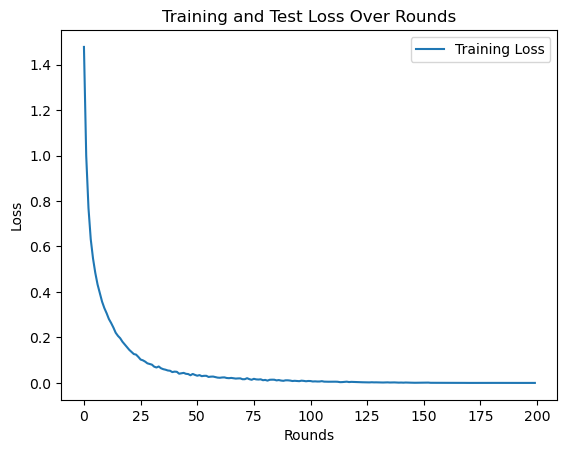

In [19]:
plt.plot(loss_train, label='Training Loss')
#plt.plot(loss_test, label='Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Rounds')
plt.legend()
plt.show()

In [19]:
# Plotting the graphs
def plot_graphs(train_accuracy, test_accuracy, train_loss, test_loss):
    plt.figure(1, figsize=(10,6))
    plt.plot(train_accuracy, label='Train Accuracy', color='red', linewidth=2)
    plt.plot(test_accuracy, label='Test Accuracy', color='blue', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Epoch Accuracy Plot")
    plt.legend()
    #plt.savefig('acc'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg', dpi=100, bbox_inches='tight')

    plt.figure(2, figsize=(10,6))
    plt.plot(train_loss, label='Train loss', color='r', linewidth=2)
    plt.plot(test_loss, label='Test loss', color='b', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Epoch Loss Plot")
    plt.legend()

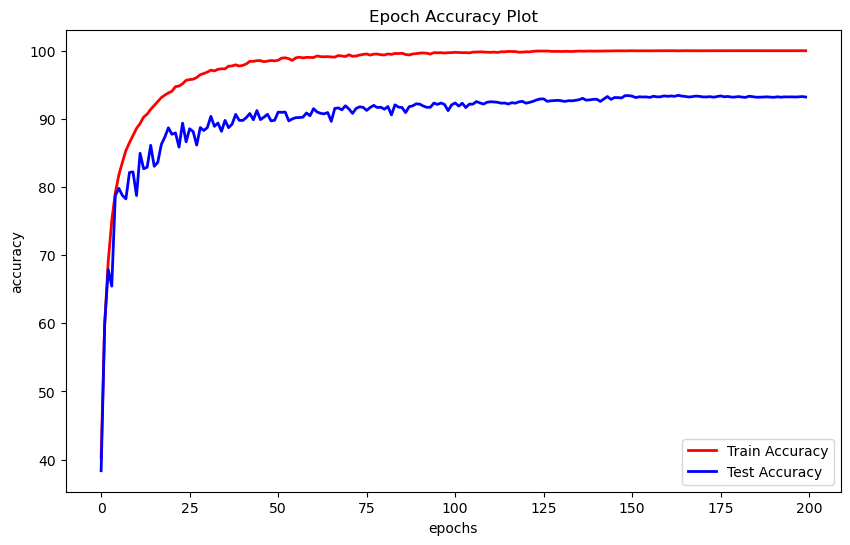

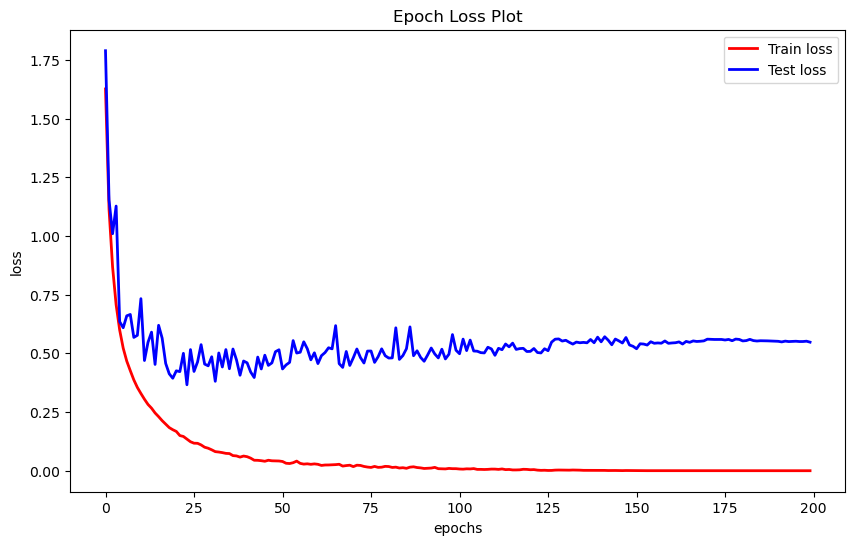

In [20]:
plot_graphs(acc_train, acc_test, loss_train, loss_test)

In [22]:
with open('central_train_accuracy.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_train}\n")

In [23]:
with open('central_test_accuracy.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_test}\n")

In [24]:
with open('central_train_loss.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_train}\n") 

In [25]:
with open('central_test_loss.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_test}\n")

In [42]:
# import ast
# with open('test_accuracy.txt', 'r') as file:
#     loaded_t_acc = file.read()
# ast.literal_eval(loaded_t_acc)

In [26]:
# visualize the test result
def evaluate_model(model):
    model.eval()
    total = 0
    correct = 0
    misclassified_examples = []
    # Class labels in CIFAR-10
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect misclassified examples
            misclassified = (predicted != labels)
            misclassified_images = images[misclassified]
            misclassified_labels = labels[misclassified]
            predicted_labels = predicted[misclassified]

            for img, true_label, pred_label in zip(misclassified_images, misclassified_labels, predicted_labels):
                if len(misclassified_examples) < 20:  # Limit the number of examples we save
                    misclassified_examples.append((img, true_label, pred_label))

    # Displaying misclassified examples
    fig, axs = plt.subplots(2, 10, figsize=(25, 5))
    for ax, example in zip(axs.flatten(), misclassified_examples):
        img, true_label, pred_label = example
        img = img.cpu().numpy().transpose((1, 2, 0))
        ax.imshow(img * 0.5 + 0.5)  # Unnormalize
        ax.set_title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}')
        ax.axis('off')

    plt.show()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

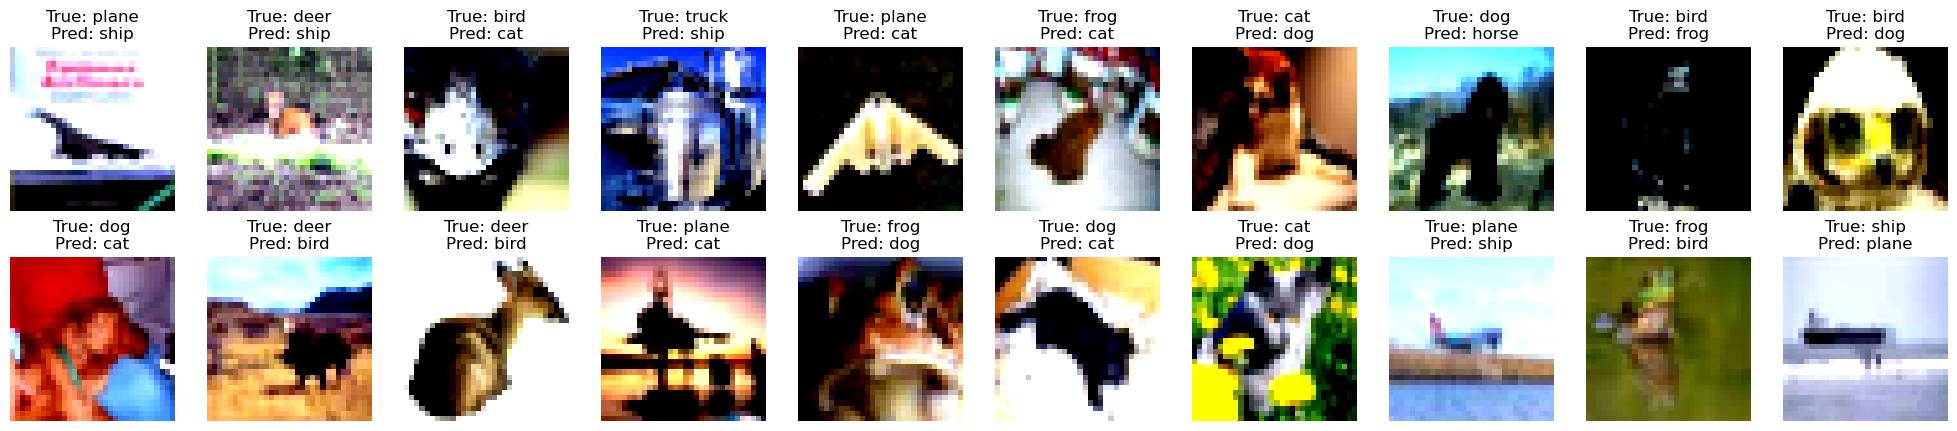

Accuracy of the network on the test images: 93 %


In [27]:
evaluate_model(global_model)

In [25]:
# # To load the entire model
fl_model = torch.load('model_resnet18.pth')
fl_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

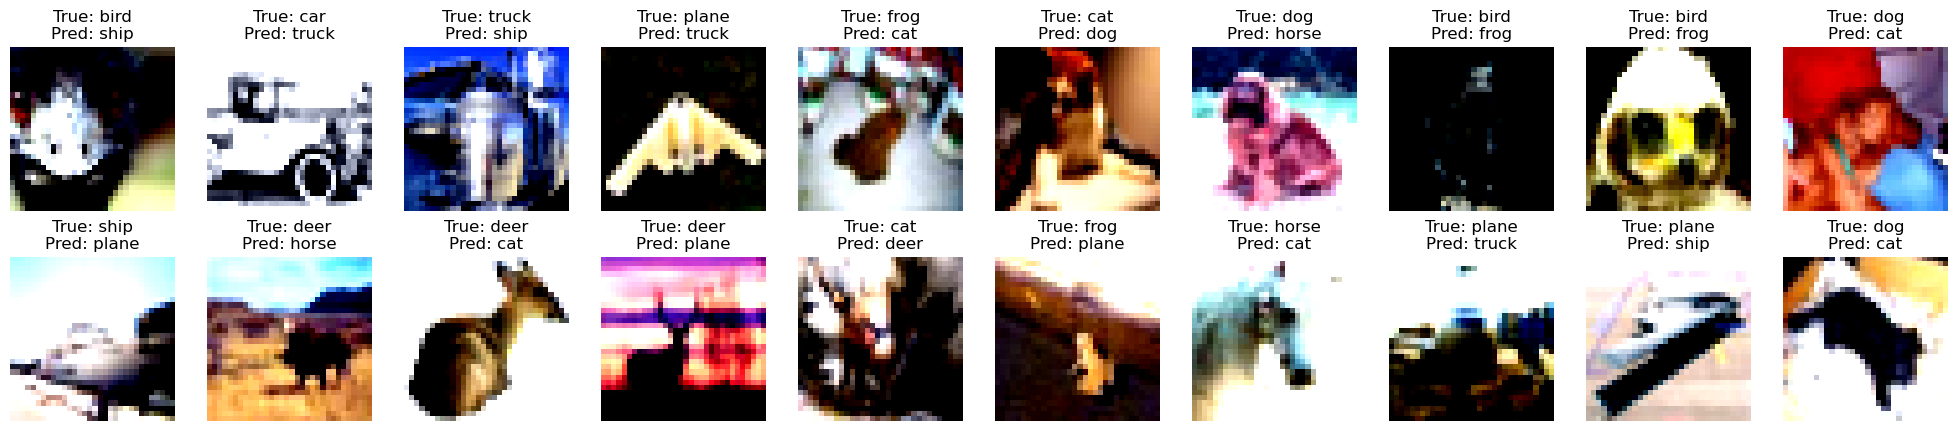

Accuracy of the network on the test images: 91 %


In [27]:
evaluate_model(fl_model.to(device))